<a href="https://colab.research.google.com/github/Chhavidotcom/predicting-the-sentiments-of-amazon-customer/blob/main/NLP_Amazon_Data_Preparation_prediction_deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting the sentiments of amazon customer reviews**

In [22]:
# import all the necessary libraries
                  
import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk    
import warnings

#Ignoring unnecessory warnings
warnings.filterwarnings("ignore") 

In [23]:
!pip install -U -q PyDrive
  
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [24]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [25]:
link = 'https://drive.google.com/file/d/1IoSOhGr9JdotSEs1PTcJvvyBlbpg8ghf/view'
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Reviews.csv')  
  
df = pd.read_csv('Reviews.csv')
print(df)

            Id  ...                                               Text
0            1  ...  I have bought several of the Vitality canned d...
1            2  ...  Product arrived labeled as Jumbo Salted Peanut...
2            3  ...  This is a confection that has been around a fe...
3            4  ...  If you are looking for the secret ingredient i...
4            5  ...  Great taffy at a great price.  There was a wid...
...        ...  ...                                                ...
568449  568450  ...  Great for sesame chicken..this is a good if no...
568450  568451  ...  I'm disappointed with the flavor. The chocolat...
568451  568452  ...  These stars are small, so you can give 10-15 o...
568452  568453  ...  These are the BEST treats for training and rew...
568453  568454  ...  I am very satisfied ,product is as advertised,...

[568454 rows x 10 columns]


In [26]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

**Data Preparation**

In [27]:
# add some columns for upvote metrics
df['Helpful %'] = np.where(df['HelpfulnessDenominator'] > 0, df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], -1)

In [28]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0


#### **assigning different different labels to helpful% according to its value**

In [29]:
df['Helpful %'].unique()

array([ 1.        , -1.        ,  0.8       ,  0.        ,  0.5       ,
        0.66666667,  0.25      ,  0.89473684,  0.83333333,  0.75      ,
        0.33333333,  0.3       ,  0.11111111,  0.42857143,  0.875     ,
        0.85714286,  0.2       ,  0.26315789,  0.6       ,  0.71428571,
        0.53846154,  0.57142857,  0.91489362,  0.86666667,  0.82352941,
        0.78571429,  0.74074074,  0.4       ,  0.375     ,  0.28571429,
        0.14285714,  0.77777778,  0.125     ,  0.9       ,  0.94117647,
        0.92307692,  0.7       ,  0.45454545,  0.88888889,  0.83870968,
        0.9047619 ,  0.92857143,  0.90909091,  0.91666667,  0.84615385,
        0.10526316,  0.98214286,  0.97826087,  0.7518797 ,  0.3125    ,
        0.1       ,  0.18518519,  0.88      ,  0.69230769,  0.625     ,
        0.54545455,  0.41666667,  0.45833333,  0.22222222,  0.81818182,
        0.8125    ,  0.16666667,  0.93103448,  0.88235294,  0.23529412,
        0.63636364,  0.81481481,  0.95652174,  0.64285714,  0.58

In [30]:
pd.cut(df['Helpful %'] , bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])

0         80-100%
1             NaN
2         80-100%
3         80-100%
4             NaN
           ...   
568449        NaN
568450        NaN
568451    80-100%
568452    80-100%
568453        NaN
Name: Helpful %, Length: 568454, dtype: category
Categories (6, object): ['Empty' < '0-20%' < '20-40%' < '40-60%' < '60-80%' < '80-100%']

In [31]:
df['%upvote'] = pd.cut( df['Helpful %'] , bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])

In [32]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,%upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,NaN


In [33]:
df.groupby(['Score', '%upvote']).agg('count')

Id  ProductId  UserId  ...  Summary    Text  Helpful %
Score %upvote                             ...                            
1     Empty      8060       8060    8060  ...     8060    8060       8060
      0-20%      2338       2338    2338  ...     2338    2338       2338
      20-40%     4649       4649    4649  ...     4649    4649       4649
      40-60%     6586       6586    6586  ...     6586    6586       6586
      60-80%     5838       5838    5838  ...     5838    5838       5838
      80-100%   12531      12531   12531  ...    12531   12531      12531
2     Empty      4234       4234    4234  ...     4234    4234       4234
      0-20%       762        762     762  ...      737     762        762
      20-40%     1618       1618    1618  ...     1618    1618       1618
      40-60%     3051       3051    3051  ...     3051    3051       3051
      60-80%     2486       2486    2486  ...     2486    2486       2486
      80-100%    7014       7014    7014  ...     7014    7014       7014
3     Empty      5062       5062    5062  ...     5062    5062       5062
      0-20%       474        474     474  ...      474     474        474
      20-40%     1506       1506    1506  ...     1506    1506       1506
      40-60%     3384       3384    3384  ...     3384    3384       3384
      60-80%     2754       2754    2754  ...     2754    2754       2754
      80-100%   11037      11037   11037  ...    11036   11037      11037
4     Empty      4780       4780    4780  ...     4780    4780       4780
      0-20%       116        116     116  ...      116     116        116
      20-40%      909        909     909  ...      909     909        909
      40-60%     3185       3185    3185  ...     3185    3185       3185
      60-80%     2941       2941    2941  ...     2941    2941       2941
      80-100%   26707      26707   26707  ...    26707   26707      26707
5     Empty     11638      11638   11638  ...    11638   11638      11638
      0-20%       432        432     432  ...      432     432        432
      20-40%     2275       2275    2275  ...     2275    2275       2275
      40-60%    10312      10312   10312  ...    10312   10312      10312
      60-80%    11060      11060   11060  ...    11060   11060      11060
      80-100%  140661     140661  140661  ...   140661  140661     140661

[30 rows x 10 columns]

#### **considering only Id Column, as I have to count Total Upvotes for different different categories**

In [34]:
df.groupby(['Score', '%upvote']).agg({'Id':'count'})

Id
Score %upvote        
1     Empty      8060
      0-20%      2338
      20-40%     4649
      40-60%     6586
      60-80%     5838
      80-100%   12531
2     Empty      4234
      0-20%       762
      20-40%     1618
      40-60%     3051
      60-80%     2486
      80-100%    7014
3     Empty      5062
      0-20%       474
      20-40%     1506
      40-60%     3384
      60-80%     2754
      80-100%   11037
4     Empty      4780
      0-20%       116
      20-40%      909
      40-60%     3185
      60-80%     2941
      80-100%   26707
5     Empty     11638
      0-20%       432
      20-40%     2275
      40-60%    10312
      60-80%    11060
      80-100%  140661

In [35]:
df_s=df.groupby(['Score', '%upvote']).agg({'Id':'count'}).reset_index()
df_s

,Score,%upvote,Id
0,1,Empty,8060
1,1,0-20%,2338
2,1,20-40%,4649
3,1,40-60%,6586
4,1,60-80%,5838
5,1,80-100%,12531
6,2,Empty,4234
7,2,0-20%,762
8,2,20-40%,1618
9,2,40-60%,3051


#### **create Pivot Table for better conclusion**





In [38]:

pivot = df_s.pivot(index='%upvote',columns='Score')
pivot

Id                            
Score        1     2      3      4       5
%upvote                                   
Empty     8060  4234   5062   4780   11638
0-20%     2338   762    474    116     432
20-40%    4649  1618   1506    909    2275
40-60%    6586  3051   3384   3185   10312
60-80%    5838  2486   2754   2941   11060
80-100%  12531  7014  11037  26707  140661

#### **create heatmap of it,for better Visualisations**

Text(0.5, 1.0, 'How helpful users find among user scores')

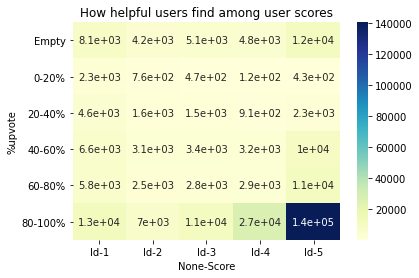

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df_s.pivot(index='%upvote',columns='Score'),annot=True,cmap = 'YlGnBu')
plt.title('How helpful users find among user scores')

In [43]:
df.shape

(568454, 12)

In [44]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,%upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,NaN


In [46]:
df['Score'].unique()

array([5, 1, 4, 2, 3])

In [47]:
df2 = df[df['Score'] != 3]
X = df2['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df2['Score'].map(y_dict)

#### **Score prediction**

### convert your text into vectors using NLP

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer(stop_words = 'english')

In [49]:
#takes almost 2 mins to execute
X_c = c.fit_transform(X)

In [50]:
print('features: {}'.format(X_c.shape[1]))

features: 114969


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_c, y)
print(' train records: {}'.format(X_train.shape[0]))

 train records: 394360


In [52]:
from sklearn.linear_model import LogisticRegression
log=LogisticRegression()

In [53]:
ml =log.fit(X_train, y_train)
acc = ml.score(X_test, y_test)
print ('Model Accuracy: {}'.format(acc))

Model Accuracy: 0.9360688910189116


#### fetch Top 20 Positive & Top 20 negative words

In [57]:
w=c.get_feature_names()
w

['00',
 '000',
 '0000',
 '000001',
 '00001',
 '000013',
 '0000soo',
 '0001',
 '000111052',
 '0002251337',
 '0003',
 '0004',
 '000iu',
 '000kwh',
 '000mg',
 '000mi',
 '000s',
 '000su',
 '000usd',
 '000v',
 '001',
 '00100',
 '00127',
 '00128',
 '00129',
 '00130',
 '00131',
 '00132',
 '00134',
 '00136',
 '00139',
 '001bru',
 '002',
 '0020100604',
 '00202',
 '00227',
 '0023',
 '003',
 '004',
 '00493',
 '005',
 '00533',
 '0060187654',
 '0060721855',
 '0060928115',
 '0060959584',
 '0061658197',
 '006176793x',
 '0067575986',
 '0069615',
 '007',
 '00703',
 '00704',
 '0071468633',
 '0071477845',
 '0071486011',
 '0071499849',
 '008',
 '0099',
 '00a',
 '00am',
 '00b',
 '00gr',
 '00lb',
 '00m',
 '00pm',
 '00s',
 '00something',
 '00z',
 '01',
 '010',
 '0100',
 '01014',
 '01069',
 '011',
 '012',
 '013',
 '01317',
 '01318',
 '014',
 '0140444254',
 '0140446680',
 '0143114964',
 '014mg',
 '015',
 '017',
 '0174',
 '018',
 '0188',
 '019',
 '01915',
 '0199232768',
 '0199535892',
 '0199536066',
 '02',
 '02

In [58]:

coef = ml.coef_.tolist()[0]
coef

[-0.4114594509598466,
 -0.06352136139735953,
 0.4687415583132845,
 -0.0070963477665874864,
 0.0014249679657528378,
 -0.013222144020793289,
 0.0003134253907970474,
 -0.014146534340950926,
 0.0005272286734335351,
 0.0,
 0.0014741897281391357,
 -0.011019005199144038,
 0.0010292089871145379,
 0.011365956850319596,
 -0.23160843921491492,
 0.00835294928350683,
 0.0,
 0.0,
 0.0010104292816404234,
 4.4414545238644854e-05,
 -0.038575928932608514,
 0.018590607618416292,
 0.03292513227126324,
 0.03292513227126324,
 0.03292513227126324,
 0.03292513227126324,
 0.03292513227126324,
 0.03292513227126324,
 0.03292513227126324,
 0.03292513227126324,
 0.03292513227126324,
 -0.00037606364508675403,
 -0.000450279891374551,
 8.013098059381083e-05,
 -0.08790511919099615,
 0.0,
 8.71437165842702e-05,
 0.002513021766040998,
 0.058339832173350314,
 1.7116536130383378e-05,
 -0.1168974250741121,
 0.011713601490109093,
 8.779917705604649e-05,
 0.002929125668047236,
 0.0,
 9.233166118893231e-05,
 0.009515658296254

In [59]:
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df

,Word,Coefficient
0,00,-0.411459
1,000,-0.063521
2,0000,0.468742
3,000001,-0.007096
4,00001,0.001425
...,...,...
114964,çaykur,0.000838
114965,çelem,0.000000
114966,être,0.019957
114967,île,0.011447


In [60]:

coeff_df = coeff_df.sort_values(['Coefficient', 'Word'],ascending=False)
coeff_df

,Word,Coefficient
80600,pleasantly,3.795836
5865,addicting,3.071255
39072,downside,2.952709
94667,skeptical,2.950012
55029,hooked,2.603447
...,...,...
88945,ripoff,-3.023588
113164,worst,-3.031013
34989,deceptive,-3.119511
88351,returnable,-3.293052


In [61]:
print('-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))
print('\n')
print('-Top 20 negative-')        
print(coeff_df.tail(20).to_string(index=False))

-Top 20 positive-
       Word  Coefficient
 pleasantly     3.795836
  addicting     3.071255
   downside     2.952709
  skeptical     2.950012
     hooked     2.603447
    worries     2.506522
   soothing     2.371225
     resist     2.365990
 economical     2.270800
   drawback     2.252302
     delish     2.178578
  excellent     2.148592
   thankful     2.136380
   hesitant     2.067675
    perfect     2.041456
   relaxing     2.023672
    easiest     1.980135
      penny     1.973422
       whim     1.969104
      saves     1.955510


-Top 20 negative-
           Word  Coefficient
     unbearable    -2.218087
       refunded    -2.228136
           skip    -2.312160
    unappealing    -2.337812
 disappointment    -2.347530
         lacked    -2.423516
          lousy    -2.458239
        vomited    -2.459015
   unacceptable    -2.510513
        defeats    -2.519292
       mediocre    -2.567524
    disapointed    -2.673034
    embarrassed    -2.780861
      cancelled    -2.961752
  

#### lets try to create a function so that I can apply mutliple NLP Techniques + Multiple Ml algos in such a way that I will acheive my best accuracy

In [62]:
### create a function 

def text_fit(X, y, nlp_model,ml_model,coef_show=1):
    
    X_c = nlp_model.fit_transform(X)
    print('features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y)
    print(' train records: {}'.format(X_train.shape[0]))
    print(' test records: {}'.format(X_test.shape[0]))
    ml =ml_model.fit(X_train, y_train)
    acc = ml.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = nlp_model.get_feature_names()
        coef = ml.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('\n')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('\n')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    


In [63]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer(stop_words = 'english')
from sklearn.linear_model import LogisticRegression

In [64]:

text_fit(X, y, c, LogisticRegression())

features: 114969
 train records: 394360
 test records: 131454
Model Accuracy: 0.9353994553227745


-Top 20 positive-
         Word  Coefficient
   pleasantly     3.811349
     downside     2.919883
    skeptical     2.746666
    addicting     2.632164
       resist     2.342834
      worries     2.206664
     soothing     2.195627
       hooked     2.156956
     drawback     2.125380
     terrific     2.068570
         whim     2.058224
     hesitant     2.014893
    excellent     1.999602
   economical     1.988574
    delighted     1.978955
       delish     1.969049
 conventional     1.963582
      awesome     1.957366
        penny     1.937124
      easiest     1.926965


-Top 20 negative-
          Word  Coefficient
    overpowers    -2.266163
    flavorless    -2.272921
       glowing    -2.278667
         ruins    -2.300074
   embarrassed    -2.312799
       vomited    -2.315977
        lacked    -2.316643
      terrible    -2.320682
        ruined    -2.350725
   disapointed  

### Lets define a predict function

In [65]:
from sklearn.metrics import confusion_matrix,accuracy_score
def predict(X, y, nlp_model,ml_model):
    
    X_c = nlp_model.fit_transform(X)
    print('features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y)
    print(' train records: {}'.format(X_train.shape[0]))
    print(' test records: {}'.format(X_test.shape[0]))
    ml =ml_model.fit(X_train, y_train)
    predictions=ml.predict(X_test)
    cm=confusion_matrix(predictions,y_test)
    print(cm)
    acc=accuracy_score(predictions,y_test)
    print(acc)

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer(stop_words = 'english')
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

In [67]:

predict(X,y,c,lr)

features: 114969
 train records: 394360
 test records: 131454
[[ 14982   2736]
 [  5619 108117]]
0.9364416449860787


#### Accuracy is around 93.9% - not bad. However we notice that some of those significant coefficients are not meaningful, e.g. 280mg.

In [74]:
from sklearn.dummy import DummyClassifier

In [75]:
### calling function for dummy classifier 
text_fit(X, y, c, DummyClassifier(),0)

features: 114969
 train records: 394360
 test records: 131454
Model Accuracy: 0.7386918617919577


#### Logistic regression model on TFIDF

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

features: 114969
 train records: 394360
 test records: 131454
Model Accuracy: 0.9343572656594702


-Top 20 positive-
       Word  Coefficient
      great    14.038651
  delicious    12.408054
       best    11.949721
    perfect    10.996100
  excellent     9.860428
      loves     9.540339
     highly     8.833514
       love     8.367997
  wonderful     8.247622
    amazing     7.923773
    awesome     7.796514
       good     7.409047
 pleasantly     7.279795
    pleased     7.279078
     hooked     7.210680
   favorite     7.143051
       nice     7.007841
      yummy     6.713805
     smooth     6.702935
       glad     6.527971


-Top 20 negative-
           Word  Coefficient
     flavorless    -5.624134
          waste    -5.653709
    undrinkable    -5.811904
          stale    -6.001374
           yuck    -6.081023
          worse    -6.133602
      tasteless    -6.364156
     disgusting    -6.389170
         return    -6.475106
          bland    -6.478541
           weak    

In [77]:

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words = 'english')
predict(X, y, tfidf, LogisticRegression())

features: 114969
 train records: 394360
 test records: 131454
[[ 14252   2319]
 [  6323 108560]]
0.9342583717498136


#### Upvote prediction

    We will be focusing on score 5 reviews, and get rid of comments with neutral votes

In [84]:
data = df[df['Score'] == 5]


In [85]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Helpful %', '%upvote'],
      dtype='object')

In [86]:
data2 = data[data['%upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
data2.shape

(154428, 12)

In [87]:
X = data2['Text']

In [88]:
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = data2['%upvote'].map(y_dict)

In [89]:
print(y.value_counts())

1.0    151721
0.0      2707
Name: %upvote, dtype: int64


#### The target class 'y' is highly skewed , we will observe positive upvotes are too much higher than negative ones.
    Let's resample the data to get balanced data:

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [91]:
tf=TfidfVectorizer()

In [92]:
X_c=tf.fit_transform(X)

In [93]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_c,y,train_size=0.7)

In [94]:
y_test.value_counts()

1.0    45534
0.0      795
Name: %upvote, dtype: int64

In [95]:
## RandomOverSampler to handle imbalanced data

from imblearn.over_sampling import RandomOverSampler

In [96]:
os =  RandomOverSampler()

In [97]:
X_train_res, y_train_res = os.fit_sample(X_c, y)

In [98]:
X_train_res.shape,y_train_res.shape

((303442, 67507), (303442,))

In [99]:
from collections import Counter

In [100]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({1.0: 151721, 0.0: 2707})
Resampled dataset shape Counter({1.0: 151721, 0.0: 151721})


In [101]:
from sklearn.linear_model import LogisticRegression

In [102]:
log_class=LogisticRegression()

In [103]:
grid={'C':10.0 **np.arange(-2,3),'penalty':['l1','l2']}

In [104]:
import numpy as np
from sklearn.model_selection import GridSearchCV

In [105]:

clf=GridSearchCV(estimator=log_class,param_grid=grid,cv=5,n_jobs=-1,scoring='f1_macro')
clf.fit(X_train_res,y_train_res)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=0)

In [106]:
y_pred=clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[  795     0]
 [  748 44786]]
0.9838546051069524
